# Tree of Thoughts (ToT)

- Author: [Sunworl Kim](https://github.com/sunworl)
- Design:
- Peer Review:
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/99-TEMPLATE/00-BASE-TEMPLATE-EXAMPLE.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/99-TEMPLATE/00-BASE-TEMPLATE-EXAMPLE.ipynb)

## Overview

Tree of Thoughts (ToT) is a systematic problem-solving framework that enhances language models' reasoning capabilities by exploring and maintaining multiple paths of thought simultaneously. 

The core concept of ToT breaks down problem-solving processes into multiple stages, where various "thoughts" are generated and evaluated at each stage, similar to how a chess player thinks several moves ahead. 

Each thought represents an independent solution path that the system explores and evaluates in parallel.



In this tutorial, we run a "Make 15" game that combines four numbers to reach 15 using an LLM agent search algorithm with Tree of Thoughts (ToT).

### Main steps

1. Expand: Creative generation phase using LLM to explore all possible equation combinations

2. Score: Validation phase that evaluates how accurately generated equations reach the target value of 15

3. Prune: Optimization phase that selects only the best candidates to determine the starting point for the next exploration

#### Key Components 

- RPN Calculator for equation evaluation
- Puzzle Generator for test cases
- LangChain-based solver 
- State-based graph management


### Table of Contents

- [Overview](#overview)
- [Environment Setup](#environment-setup)
- [Tesk Definition](#task-definition)
- [Number Combination Puzzle Generator](#number-combination-puzzle-generator)
- [Expander](#expander)
- [Scorer](#scorer)
- [Define Graphs](#define-graphs)
- [Running the Graph](#running-the-graph)


### References

- [Tree of Thoughts: Deliberate Problem Solving with Large Language Models](https://doi.org/10.48550/arXiv.2305.10601)
- [Langgraph tutorials: tot](https://github.com/langchain-ai/langgraph/tree/f239b39060096ab2c8bff0d6303781efee174a5c/docs/docs/tutorials/tot)

----

## Environment Setup

Setting up your environment is the first step. See the [Environment Setup](https://wikidocs.net/257836) guide for more details.

**[Note]**
- The langchain-opentutorial is a package of easy-to-use environment setup guidance, useful functions and utilities for tutorials. 
- Check out the  [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [80]:
%%capture --no-stderr
%pip install -U langchain-opentutorial

In [81]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langsmith",
        "langchain",
        "langchain_openai",
        "langchain_core",
        "langgraph.constants",
        "langgraph.checkpoint"
    ],
    verbose=False,
    upgrade=False,
)

You can set API keys in a `.env` file or set them manually.

[Note] If you’re not using the `.env` file, no worries! Just enter the keys directly in the cell below, and you’re good to go.

In [82]:
from dotenv import load_dotenv
from langchain_opentutorial import set_env

# Attempt to load environment variables from a .env file; if unsuccessful, set them manually.
if not load_dotenv():
    set_env(
        {
            "OPENAI_API_KEY": "",
            "LANGCHAIN_API_KEY": "",
            "LANGCHAIN_TRACING_V2": "true",
            "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
            "LANGCHAIN_PROJECT": "Tree of Thoughts (ToT)",
        }
    )

Environment variables have been set successfully.


## Task Definition

Defines the task for the agent to perform the **Make of 15** game.

- `Equation` : Key function for evaluating mathematical expressions. This class represents a mathematical equation using Reverse Polish Notation (RPN).

- `GuessEquations`: Container to bundles multiple equations with an explanation of the reasoning behind them.

- `Candidate`: A class that stores a candidate equation and its corresponding evaluation results.

- `ScoredCandidate`: A class that represents a candidate equation that has been fully evaluated and scored.

In [83]:
import operator
from typing import List, Literal, Union, NamedTuple, Optional
from pydantic import BaseModel, Field, field_validator

# Define the available operators and token type
OperatorType = Literal["+", "-", "*", "/"]  
TokenType = Union[float, OperatorType]


# Formula for combining numbers to reach 15 using RPN
class Equation(BaseModel):
    tokens: List[TokenType] = Field(
        description="The stack of tokens and operators in reverse-polish notation. Example: [3, 4, '+', -1, '*'] would evaluate to (3 + 4) * -1 = -7."
    )

    @field_validator('tokens')
    def clean_tokens(cls, v):
        return [float(t) if isinstance(t, (int, float)) else t.strip() for t in v]

    # Validate operators 
    def validate_tokens(cls, v): 
        cleaned_tokens = []
        for token in v:
            if isinstance(token, str):
                token = token.strip()
                if token not in {'+', '-', '*', '/'}:
                    raise ValueError(f"Invalid operator: {token}")
            cleaned_tokens.append(token)
        return cleaned_tokens

    def compute(self) -> float:
        op_funcs = {
            "+": operator.add,
            "-": operator.sub,
            "*": operator.mul,
            "/": operator.truediv,
        }
        stack = []
        for token in self.tokens:
            if isinstance(token, float):
                stack.append(token)
            else:
                b, a = stack.pop(), stack.pop()
                stack.append(op_funcs[token](a, b))

        return stack[0]


# Container for multiple guess equations and their inferences
class GuessEquations(BaseModel):
    reasoning: str = Field(
        description="The reasoning behind the submitted guesses. Explain how you arrived at these equations."
    )
    equations: List[Equation] = Field(  
        description="The list of equations to submit as guesses."
    )

# Indicates a candidate equation to be evaluated
class Candidate(NamedTuple):
    candidate: Equation              # Equations to be evaluated
    score: Optional[float] = None    # Evaluation score of equations
    feedback: Optional[str] = None   # Feedback on the evaluation

    # Representation of Output
    def __str__(self):
        try:
            computed = self.candidate.compute()
            return f"Equation({self.candidate.tokens}) = {computed:.2f} (Score: {self.score:.2f if self.score is not None else 'N/A'})" 
        except Exception as e:
            return f"Invalid equation: {self.candidate.tokens}; Error: {str(e)}"

class ScoredCandidate(Candidate):
    candidate: Equation
    score: float
    feedback: str        

## Number Combination Puzzle Generator

Create a number puzzle that matches the specified number and range.

In [84]:
import itertools
import random

def generate_make_puzzles(count=10, seed=None):
    if seed is not None:
        random.seed(seed)
    
    numbers = list(range(1, 10))
    all_combinations = list(itertools.combinations(numbers, 4))
    selected_combinations = random.sample(all_combinations, min(count, len(all_combinations)))
    
    return [" ".join(map(str, combo)) for combo in selected_combinations]

# Example of generated number puzzles
puzzles = generate_make_puzzles()
print(f"Example puzzles: {puzzles[:3]}")

Example puzzles: ['1 3 6 9', '5 7 8 9', '2 3 8 9']


## Expander

The **"tree of thoughts"** algorithm is relatively generic. The primary two task-specific components are the **expander** and the **scorer**. The expander (the augmented LLM) tries to generate 1 or more solutions to the problem. On subsequent attempts, it is given a seed/candidate value from the previous search.

You can update this section to match your own task requirements. The expander can be arbitrarily complex. All that's required is that it accepts the problem and an optional previous attempt (or attempts) and returns a new result.


In [85]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI


# Define the Prompt Template
prompt = ChatPromptTemplate.from_messages(
    [
        ( # System prompt: Define the rules of the "Make 15" game
            "system",
            """You are playing Make 15. Create equations that evaluate to exactly 15 using the provided numbers.
            Rules:
            1. Use each number exactly once
            2. You can use +, -, *, / operators
            3. The result must be exactly 15
            4. Submit {k} different valid guesses
            
            Evaluate your guesses carefully before submitting."""
        ),

        ( # User prompt: Includes the number to use and a history of previous attempts
            "user", 
            "Numbers to use: {problem}\nPrevious attempt (if any): {candidate}"
        ),
    ],
).partial(candidate="")
llm = ChatOpenAI(model="gpt-4o-mini")

bound_llm = llm.with_structured_output(GuessEquations)   # Output setting
solver = prompt | bound_llm   # Create pipeline

## Scorer

In this game, the calculation of scores must satisfy the following conditions.

1. Each given number should be used exactly once.
2. The result of the calculation should be 15.


In [86]:
def compute_score(problem: str, candidate: Candidate) -> ScoredCandidate:
    numbers = list(map(float, problem.split()))
    used_numbers = [
        token for token in candidate.candidate.tokens if isinstance(token, (int, float))
    ]
    # Check if every number is used exactly once
    if sorted(used_numbers) != sorted(numbers):
        return ScoredCandidate(
            candidate=candidate.candidate,
            score=0,
            feedback="The equation must use all 4 numbers exactly once."
        )
    # Score between 0 and 1 based on difference from 15    
    try:
        result = candidate.candidate.compute()
        score = max(0.0, 1.0 - abs(result - 15) / 15)
        feedback = f"Result: {result}"
    except Exception as e:
        return ScoredCandidate(
            candidate=candidate.candidate,
            score=0, 
            feedback=f"Invalid equation. Error: {repr(e)}"
        )
           
    return ScoredCandidate(
        candidate=candidate.candidate,
        score=score,
        feedback=feedback
    )


## Define Graphs

It implements the Make 15 game with graph-based state management and uses the **Tree of Thoughts (ToT)** method to find the optimal answer.

The main process proceeds in the following order: creation (expand) -> score calculation (score) -> pruning (prune).

**State management classes**

- `ToTState` : Manages problems, candidates, scored candidates, and depth

- `Configuration` : set maximum depth, threshold, k, beam size, etc

- `ExpansionState` : Status for ToT expansion

**Main functions**

- `expand()`: Generate new candidate answers using LLM

- `score()`: Calculate the score for each candidate answer

- `prune()`: Select only candidates with top scores

- `should_terminate()`: Check termination conditions

- `create_graph()`: Generate full execution graph


In [87]:
import operator
from typing import Optional, Dict, Any
from typing_extensions import Annotated, TypedDict
from langgraph.graph import StateGraph

from langchain_core.runnables import RunnableConfig
from langgraph.constants import Send
from langgraph.checkpoint.memory import MemorySaver


def update_candidates(
    existing: Optional[list] = None,
    updates: Optional[Union[list, Literal["clear"]]] = None,
) -> List[str]:
    if existing is None:
        existing = []
    if updates is None:
        return existing
    if updates == "clear":
        return []
    # Concatenate the lists
    return existing + updates


class ToTState(TypedDict):
    problem: str
    candidates: Annotated[List[Candidate], update_candidates]
    scored_candidates: Annotated[List[ScoredCandidate], update_candidates]
    depth: Annotated[int, operator.add]


class Configuration(TypedDict, total=False):
    max_depth: int
    threshold: float
    k: int
    beam_size: int



def _ensure_configurable(config: RunnableConfig) -> Configuration:
    configurable = config.get("configurable", {})
    return {
        **configurable,
        "max_depth": configurable.get("max_depth", 10),
        "threshold": config.get("threshold", 1.0), 
        "k": configurable.get("k", 5),
        "beam_size": configurable.get("beam_size", 3),
    }


class ExpansionState(ToTState):
    seed: Optional[Candidate]

# Create new candidates using LLM
def expand(state: ExpansionState, *, config: RunnableConfig) -> Dict[str, List[str]]:
   configurable = _ensure_configurable(config)

   # Ensure problem is a string
   problem = state["problem"]
   if isinstance(problem, list):
       problem = problem[0]


   try:
        equation_submission = solver.invoke(
            {
                "problem": problem,
                "candidate": str(state.get("seed", "")),
                "k": configurable["k"],
            },
            config=config,
        )
        return {
            "candidates": [
                Candidate(candidate=eq) 
                for eq in equation_submission.equations
                if all(t in {'+', '-', '*', '/'} or isinstance(t, (int, float)) 
                    for t in eq.tokens)
            ]
        }
   except Exception as e:
        return {"candidates": []}


# Calculate the score for each candidate equation
def score(state: ToTState) -> Dict[str, List[ScoredCandidate]]:
    candidates = state.get("candidates", [])
    if not isinstance(candidates, list):
        return {"scored_candidates": [], "candidates": "clear"}        
    scored = [
        compute_score(state["problem"], candidate) 
        for candidate in candidates 
        if hasattr(candidate, 'candidate')
    ]
    return {"scored_candidates": scored, "candidates": "clear"}


# Choose the candidates with the best results
# Keep only top candidates as big as beam_size
def prune(state: ToTState, *, config: RunnableConfig) -> Dict[str, List[Dict[str, Any]]]:
    scored_candidates = state["scored_candidates"]
    beam_size = _ensure_configurable(config)["beam_size"]
    organized = sorted(
        scored_candidates, 
        key=lambda x: x.score if isinstance(x, ScoredCandidate) else -float('inf'),
        reverse=True
    )
    pruned = organized[:beam_size]
    return {
        "candidates": pruned, # Update the starting point for the next iteration
        "scored_candidates": "clear", # Clear the old memory
        "depth": 1, # Increment the depth by 1
    }


# Determine the next step by checking if the correct answer has been found or maximum depth has been reached
def should_terminate(state: ToTState, config: RunnableConfig):
    configurable = _ensure_configurable(config)
    if not state["candidates"]:
        return "__end__"
    
    best_candidate = state["candidates"][0]
    solved = isinstance(best_candidate, ScoredCandidate) and abs(best_candidate.score - 1.0) < 1e-6
    
    if solved or state["depth"] >= configurable["max_depth"]:
        return "__end__"
    
    return [Send("expand", {**state, "seed": candidate}) for candidate in state["candidates"]]


# Create the graph
def create_graph(config: Configuration = None) -> StateGraph:
    if config is None:
        config = {
            "max_depth": 10,
            "threshold": 1.0,
            "k": 5,
            "beam_size": 3
        }

    builder = StateGraph(state_schema=ToTState, config_schema=Configuration)

    # Add nodes : expand, score, prune
    builder.add_node(expand)
    builder.add_node(score)
    builder.add_node(prune)

    # Add edges : Define the execution order between nodes
    builder.add_edge("expand", "score")
    builder.add_edge("score", "prune")
    builder.add_conditional_edges("prune", should_terminate, path_map=["expand", "__end__"])

    # Set entry point
    builder.add_edge("__start__", "expand")

    return builder.compile(checkpointer=MemorySaver())

Visualize the compiled graph structure.

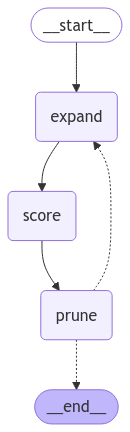

In [88]:
from IPython.display import Image, display

display(Image(create_graph().get_graph().draw_mermaid_png()))

## Running the Graph
Start the **"Make 15"** game.

In [89]:
config = {
    "configurable": {
        "thread_id": "make15_test",
        "max_depth": 10,
        "threshold": 1.0,
        "k": 5,
        "beam_size": 3
    },
    "recursion_limit": 50
}

# Graph initialization
graph = create_graph()

# Create a puzzle for testing
puzzle = generate_make_puzzles(1, seed=42)[0]
print(f"New puzzle: {puzzle}")

# Run in a stream manner and monitor each step
for step in graph.stream({"problem": puzzle}, config):
    print(f"Step: {step}")

New puzzle: 2 5 6 7
Step: {'expand': {'candidates': [Candidate(candidate=Equation(tokens=[6.0, 5.0, 2.0, 7.0, '+', '*']), score=None, feedback=None), Candidate(candidate=Equation(tokens=[7.0, 2.0, '*', 5.0, '+', 6.0, '-']), score=None, feedback=None), Candidate(candidate=Equation(tokens=[5.0, 6.0, 2.0, '*', 7.0, '-']), score=None, feedback=None), Candidate(candidate=Equation(tokens=[2.0, 5.0, 7.0, '*', 6.0, '-']), score=None, feedback=None), Candidate(candidate=Equation(tokens=[6.0, 2.0, '*', 7.0, '+', 5.0]), score=None, feedback=None)]}}
Step: {'score': {'scored_candidates': [ScoredCandidate(candidate=Equation(tokens=[6.0, 5.0, 2.0, 7.0, '+', '*']), score=0.4, feedback='Result: 6.0'), ScoredCandidate(candidate=Equation(tokens=[7.0, 2.0, '*', 5.0, '+', 6.0, '-']), score=0.8666666666666667, feedback='Result: 13.0'), ScoredCandidate(candidate=Equation(tokens=[5.0, 6.0, 2.0, '*', 7.0, '-']), score=0.33333333333333337, feedback='Result: 5.0'), ScoredCandidate(candidate=Equation(tokens=[2.0

Display the Final Results corresponding to the top three scores.

In [90]:
def print_results(graph: StateGraph, config: dict):
    # Get final status
    final_state = graph.get_state(config)
    # Extract candidate solutions
    candidates = final_state.values["candidates"]
 
    print("\nFinal Results:")
    print("-" * 50)
    for i, candidate in enumerate(candidates, 1):
        print(f"Solution {i}: {candidate}")
    print("-" * 50)

final_state = graph.get_state(config)
best_solution = final_state.values["candidates"][0]  # Extract the highest score answer
search_depth = final_state.values["depth"]  # Check search depth


print_results(graph, config)


Final Results:
--------------------------------------------------
Solution 1: [Equation(tokens=[6.0, 5.0, '+', 2.0, '*', 7.0, '-']), 1.0, 'Result: 15.0']
Solution 2: [Equation(tokens=[7.0, 2.0, '*', 5.0, '+', 6.0, '-']), 0.8666666666666667, 'Result: 13.0']
Solution 3: [Equation(tokens=[6.0, 2.0, '*', 5.0, '+', 7.0]), 0.8666666666666667, 'Result: 17.0']
--------------------------------------------------
